In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from functools import partial

from prepare_plasticc import config
from tokenizer import LCTokenizer
from viz import plot_lightcurve
from gp import fit_2d_gp
import time

In [2]:
df = pd.read_csv('plasticc/plasticc_train_lightcurves.csv.gz')
#df = pd.read_csv('plasticc/plasticc_test_lightcurves_02.csv.gz')

In [3]:
object_ids = np.unique(df['object_id'].values)

In [4]:
tokenizer = LCTokenizer(config["min_flux"], config["max_flux"], config["num_bins"], config["max_delta_time"],
                            config["num_time_bins"], bands=config["bands"],
                            transform=np.arcsinh, inverse_transform=np.sinh,
                            min_sn=3, window_size=5)

In [10]:
start_time = time.time()
tokenizer.encode(df)
print(time.time() - start_time)

2.9987242221832275


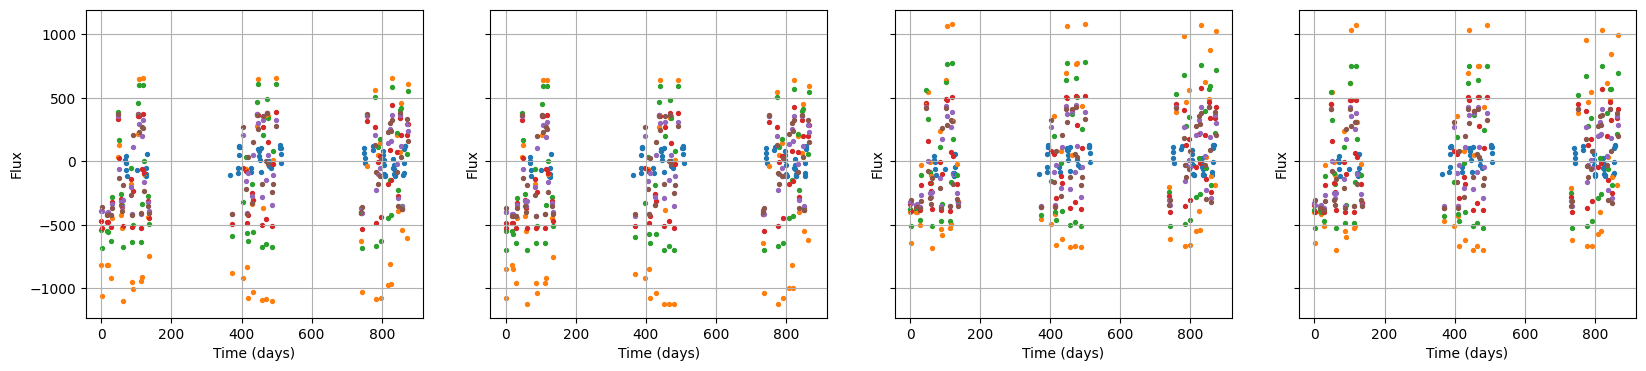

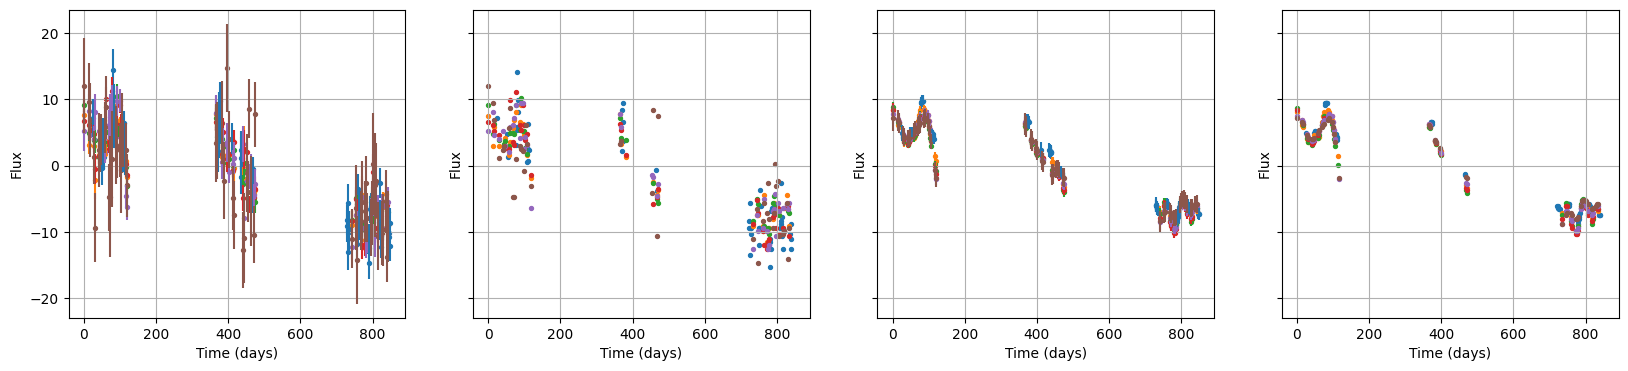

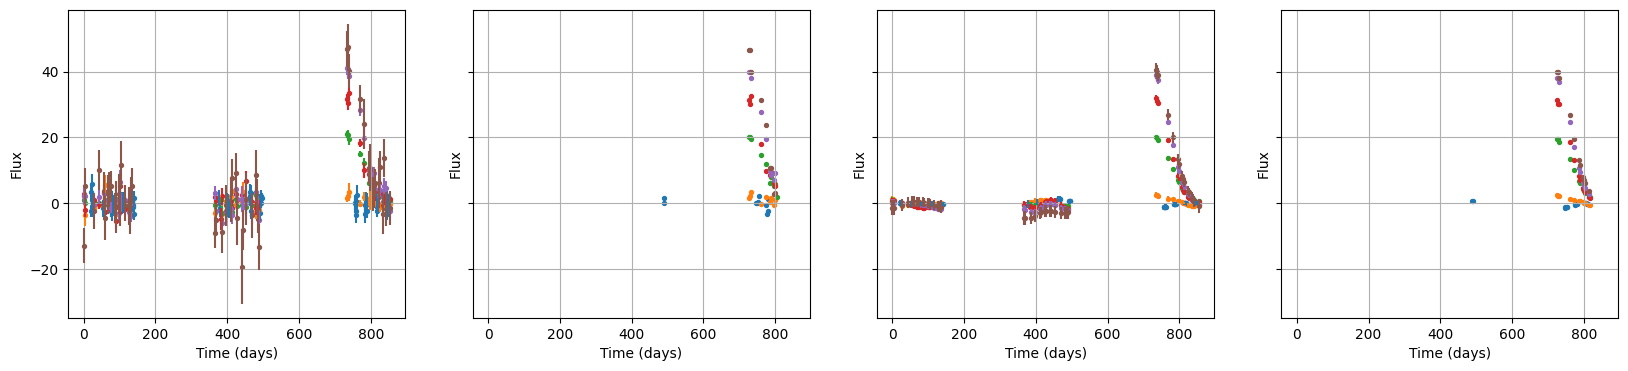

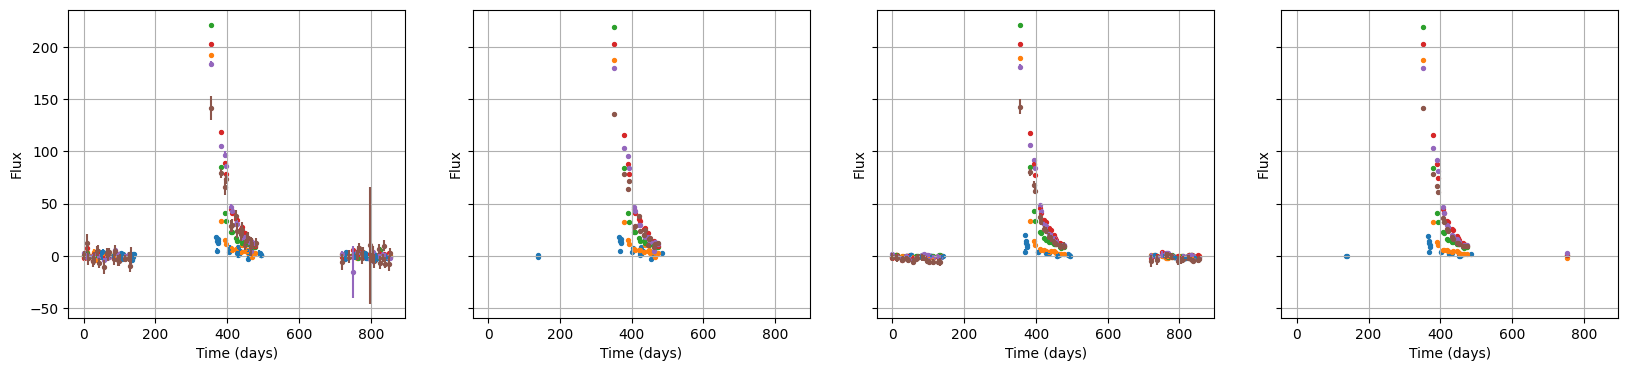

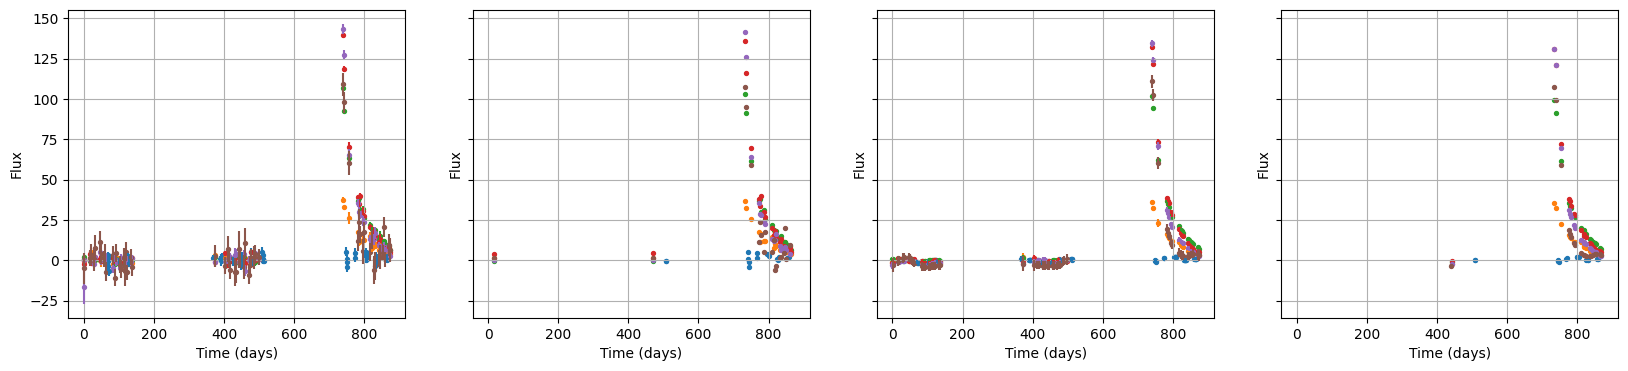

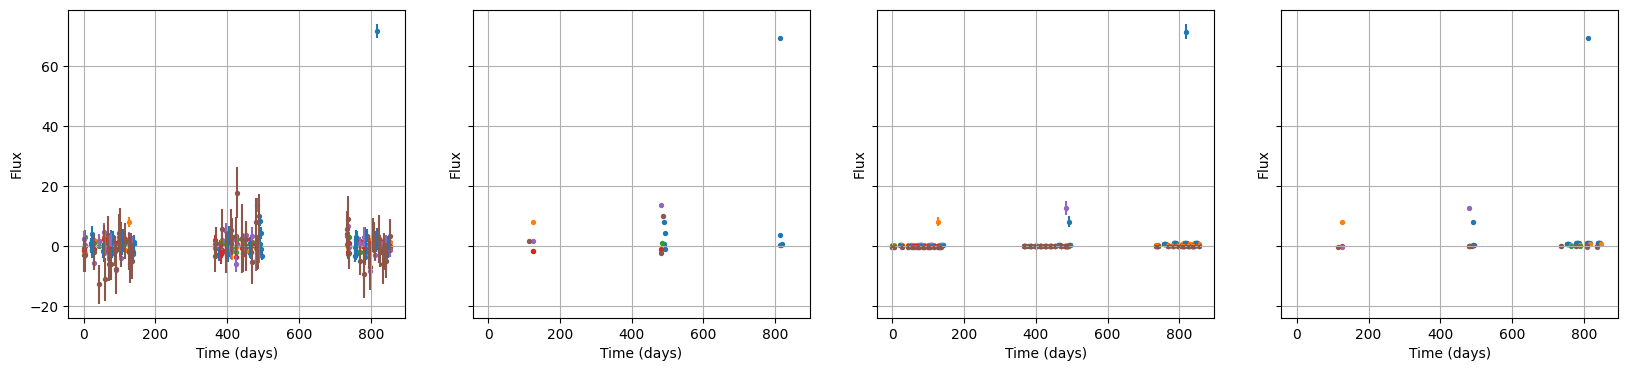

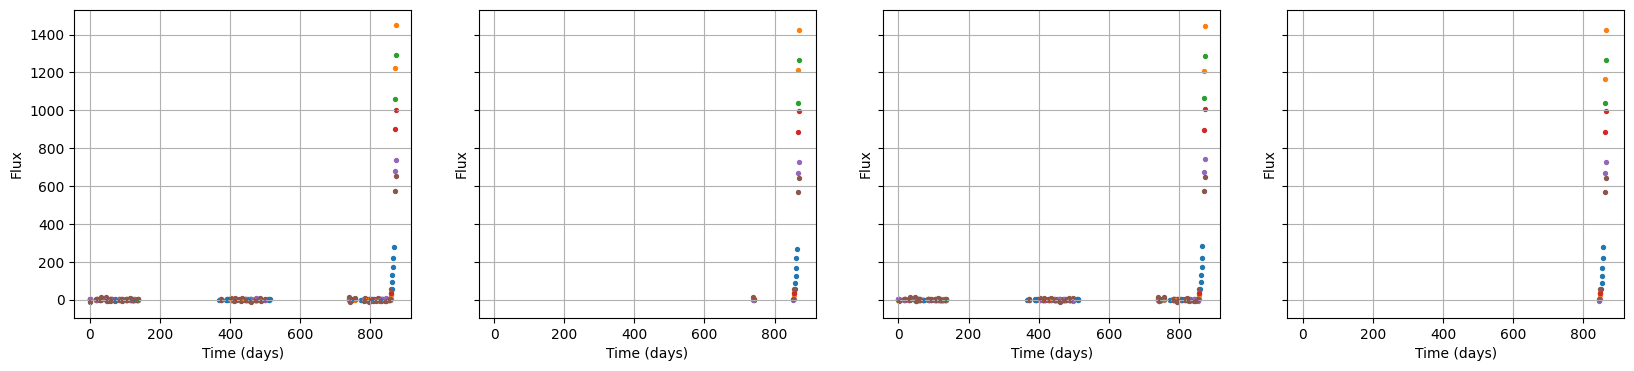

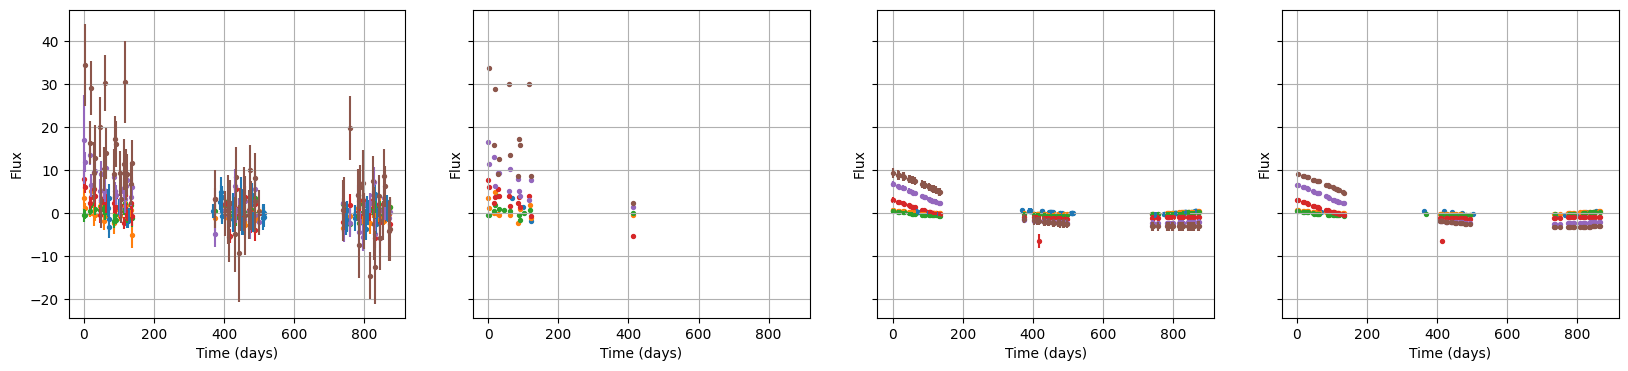

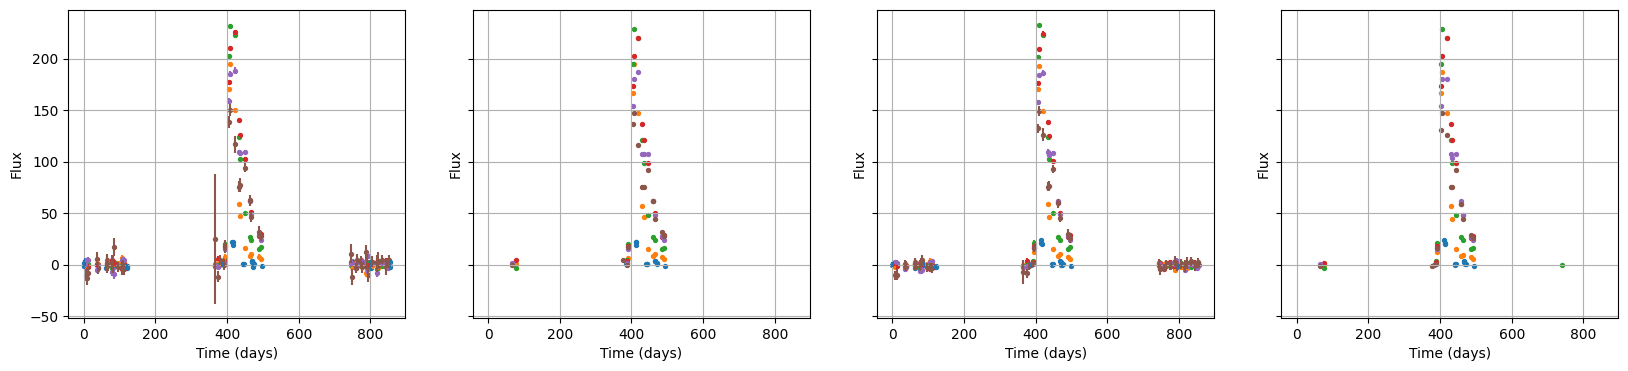

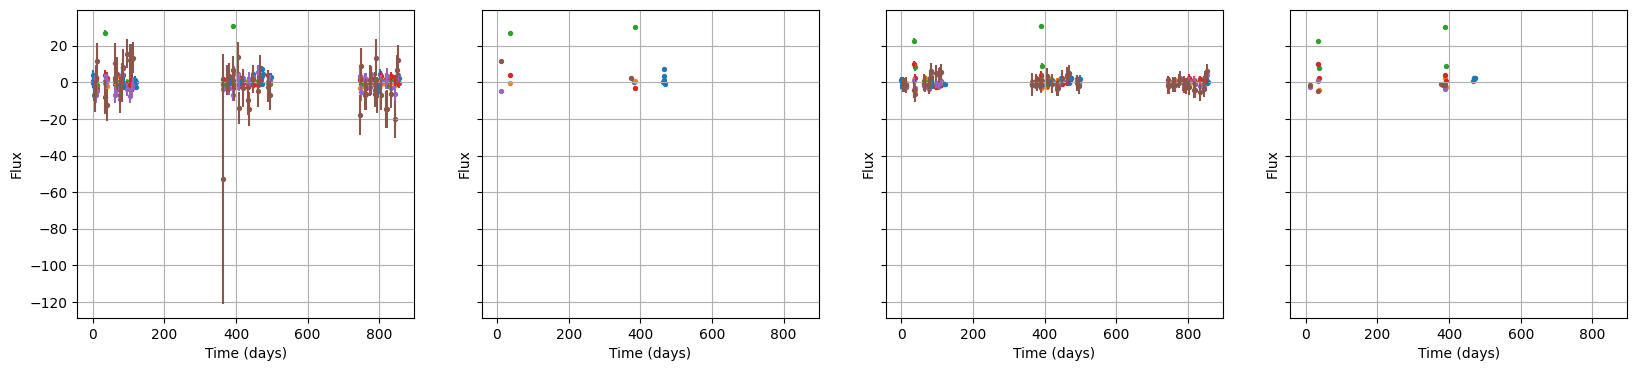

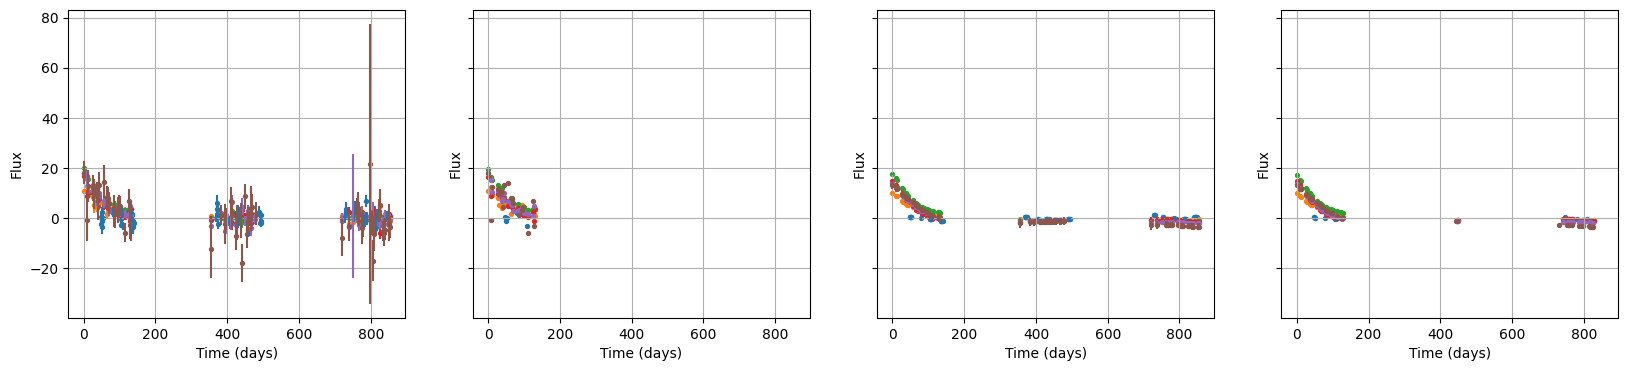

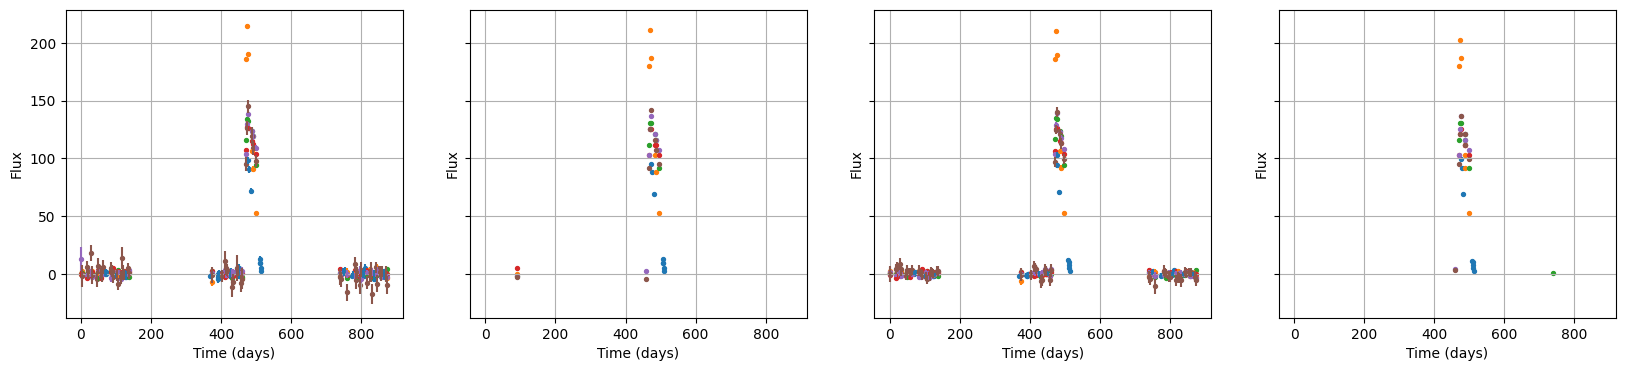

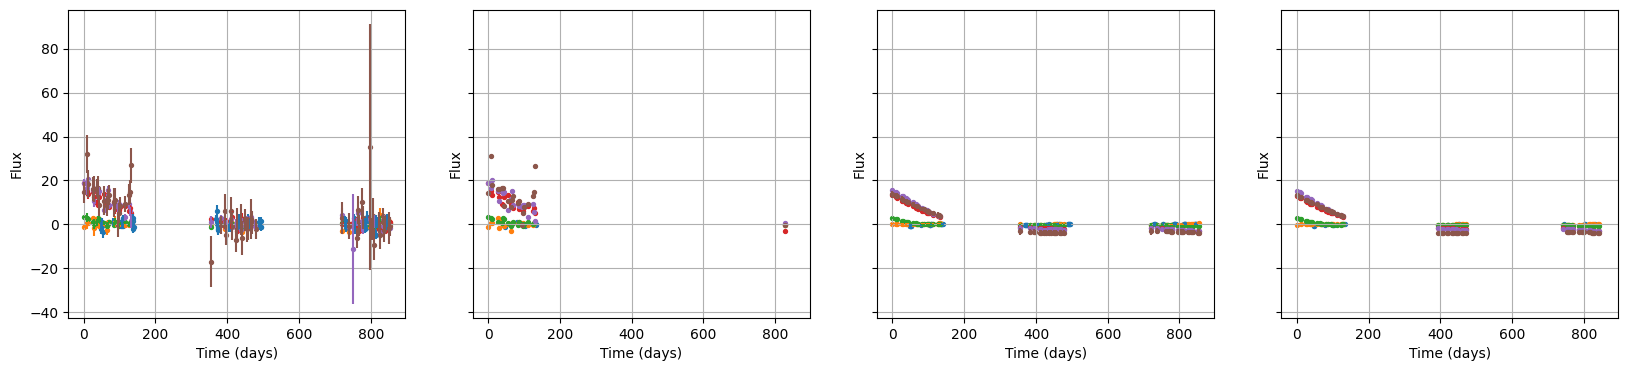

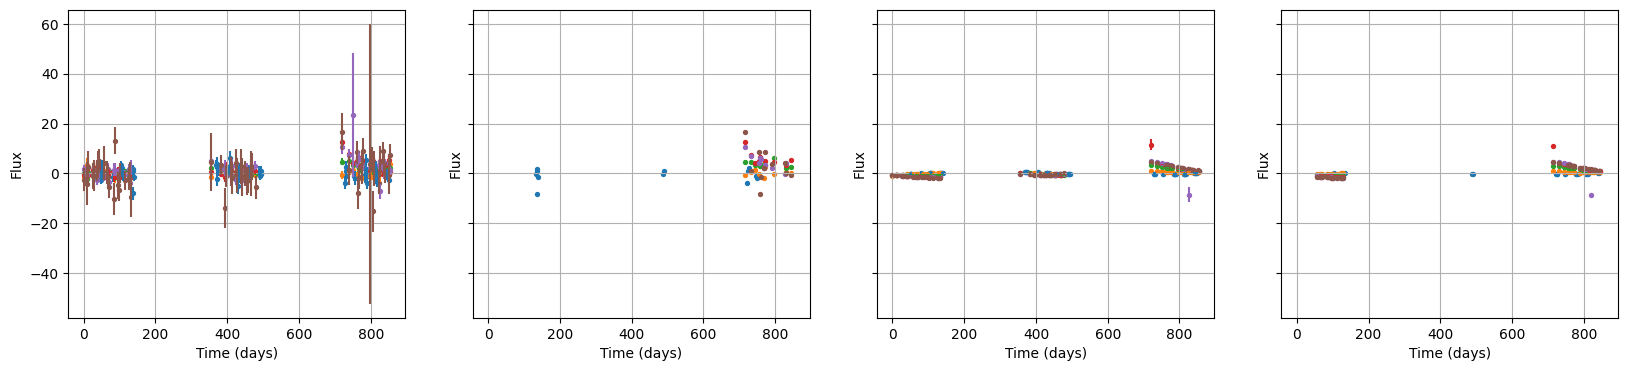

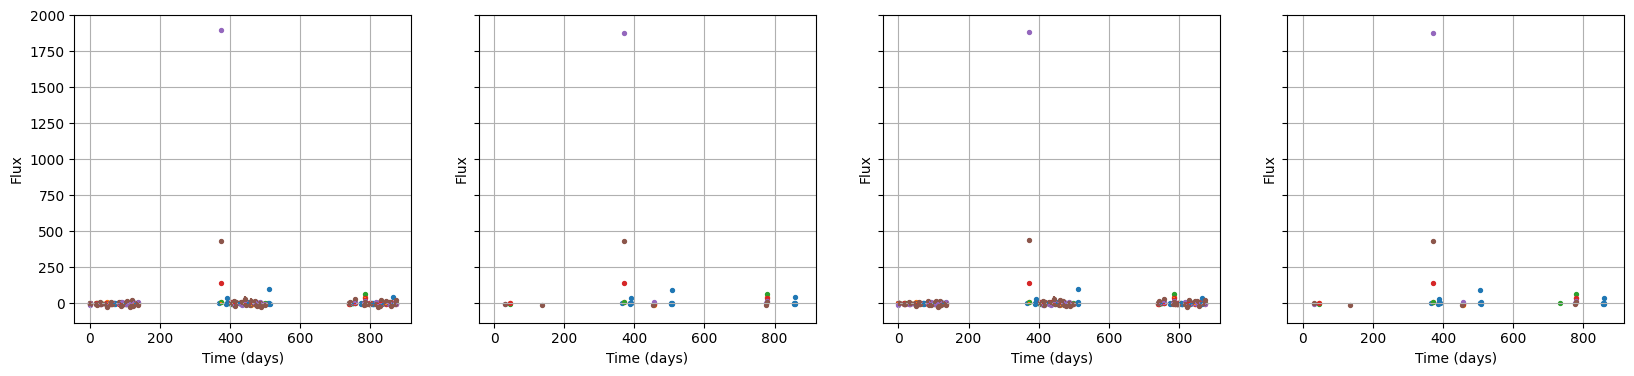

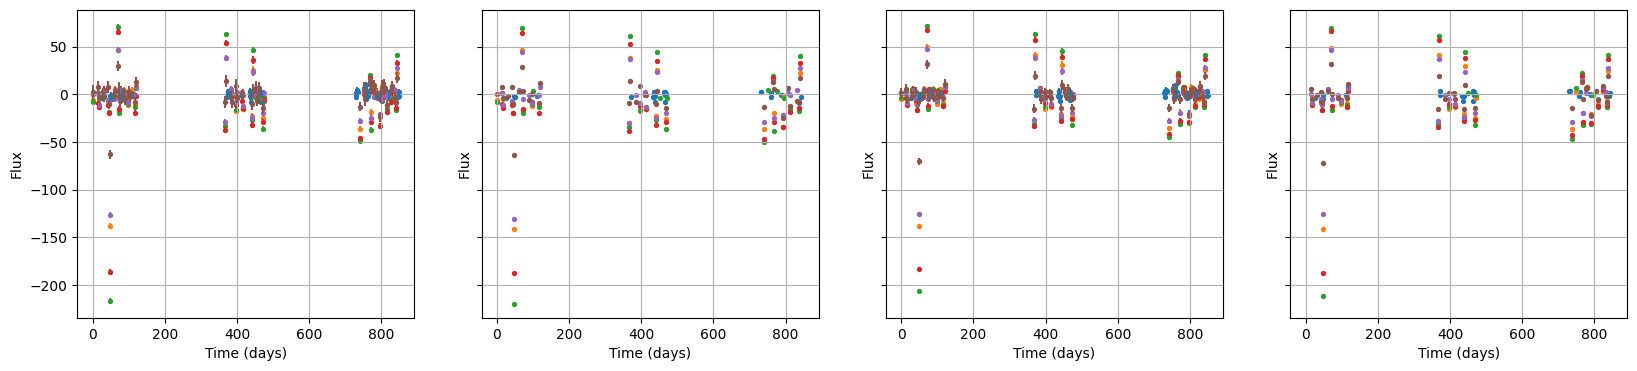

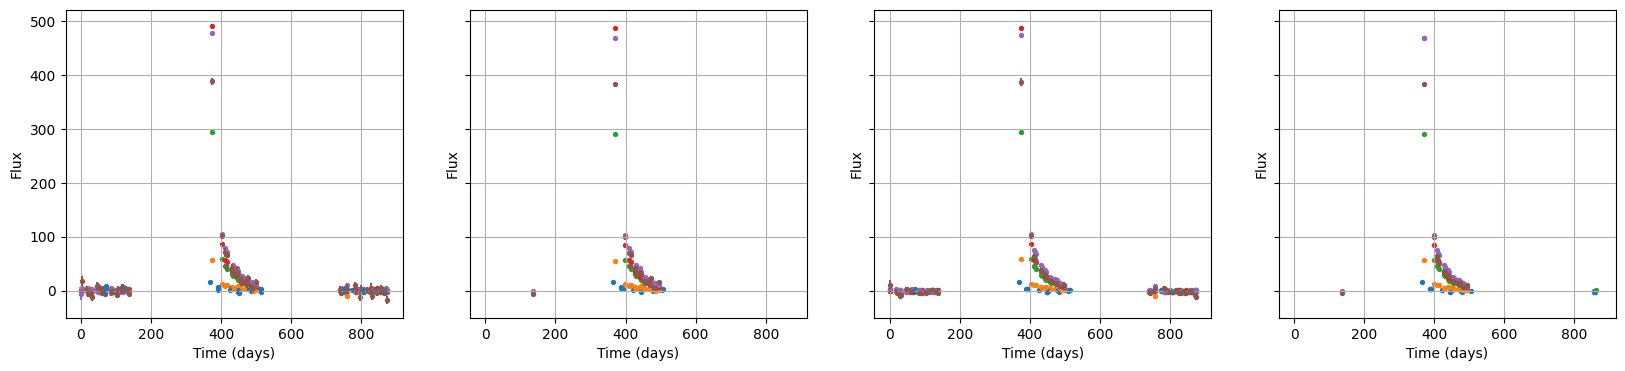

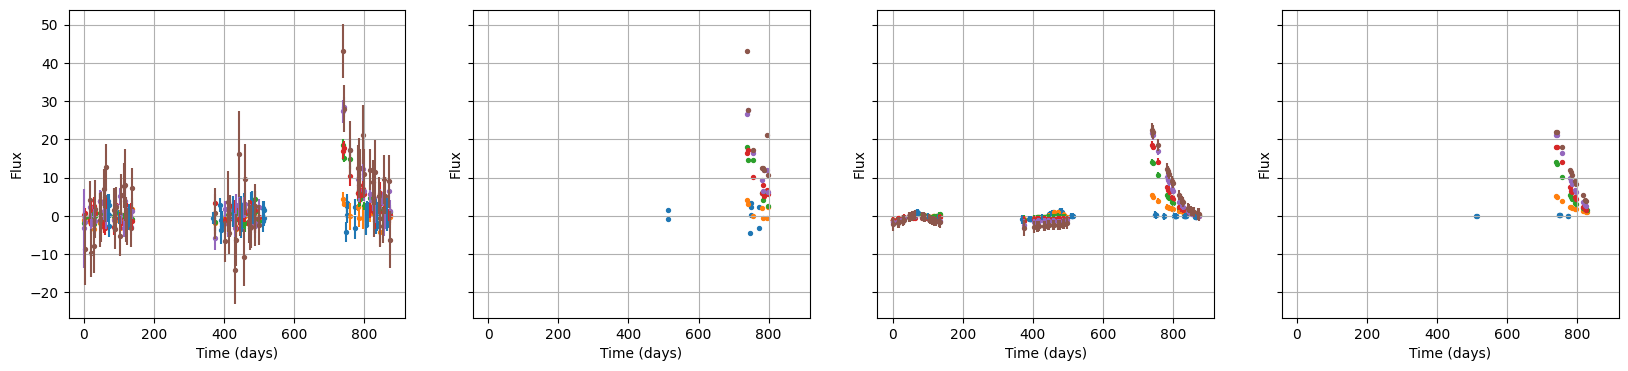

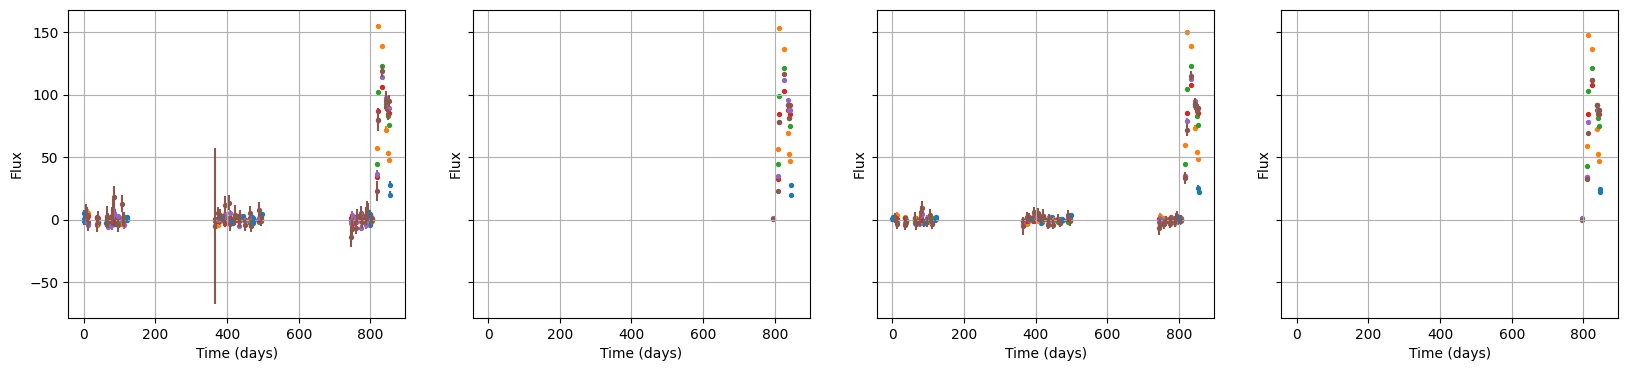

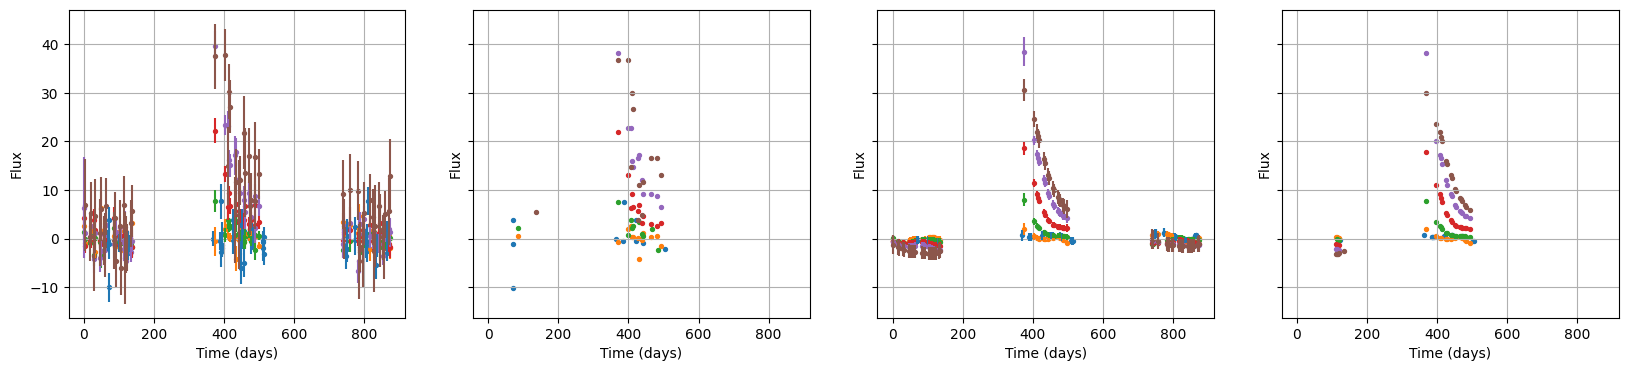

In [8]:
for object_id in object_ids[0:20]:
    df_object = df.loc[df['object_id'] == object_id]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    resampled_df, resampled_obs = fit_2d_gp(df_object, config['pb_wavelengths'])
    plot_lightcurve([df_object, tokenizer.decode(tokenizer.encode(df_object)), resampled_df, tokenizer.decode(tokenizer.encode(resampled_df))])

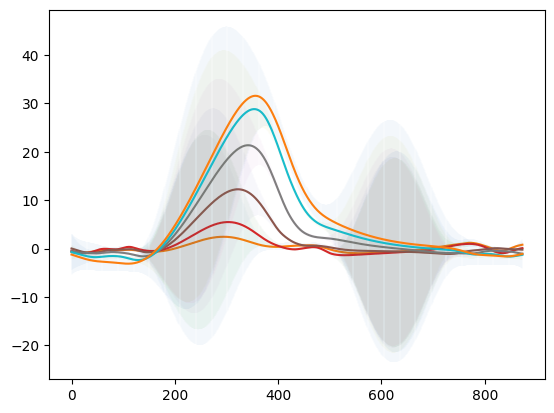

In [9]:
for i in range(6):
    plt.errorbar(resampled_obs[0], resampled_obs[1][i,0,:], resampled_obs[1][i,1,:], alpha=0.01)
    plt.plot(resampled_obs[0], resampled_obs[1][i,0,:])
